In [1]:
import pandas as pd
import numpy as np
import os

# 
#os.chdir(r'E:\OneDrive\NUS\BT4016 Risk Analytics\Project/')
startDate = '2020-02-02' #<----PARAM
endDate = '2022-02-01' #<----PARAM

# Q5

# BTC & ETH

### ///-------  volatility of the underlying coin in pct return  -------\\\  ###
BTC_raw = pd.read_csv('BTC_table.csv')  # this is also allocation table from unconstrained
ETH_raw = pd.read_csv('ETH_table.csv')  # this is also allocation table from unconstrained

In [2]:
BTC_raw['price_USD_lag1'] = BTC_raw['price_USD'].shift(1)
BTC_raw['log_return'] = np.log(BTC_raw['price_USD']/BTC_raw['price_USD_lag1'])
BTC_return_vol = BTC_raw['log_return'].std()*365**0.5*100  # annualize

ETH_raw['price_USD_lag1'] = ETH_raw['price_USD'].shift(1)
ETH_raw['log_return'] = np.log(ETH_raw['price_USD']/ETH_raw['price_USD_lag1'])
ETH_return_vol = ETH_raw['log_return'].std()*365**0.5*100  # annualize

# total return volatility, non-directional
print('BTC log return volatility annualized pct:',BTC_return_vol)
print('ETH log return volatility annualized pct:',ETH_return_vol)

"""
ETH is more volatile return-wise
"""

BTC log return volatility annualized pct: 78.55740229307276
ETH log return volatility annualized pct: 104.31100675127634


'\nETH is more volatile return-wise\n'

In [3]:
ETH_price_vol = ETH_raw['price_USD'].std()  # to use in part b
BTC_price_vol = BTC_raw['price_USD'].std()  


### ///-------  Option Raw Analysis  -------\\\  ###
    # use unconstrained port 
    # load option data and clean, timewise also need to sort
    # buy one straddle (buy one put + buy one call). That expires on 2021/01/08
    #   on the most volatile ticker
    # the straddle can have X = [-1 SD,same] put and [same, +1 SD] call 
"""
    You can choose the exercise prices as close as to minus/plus one 
    standard deviation of asset return (minus one standard deviation for buying a put and plus one 
    standard deviation for buying a call option). You can determine your cost using the last 
    transacted option prices on 2021/01/01 as the market price. Suppose your cost is externally 
    financed and to be returned/deducted on 2021/01/08, with no interest rate. 
    What are the instrument_ids that you decided to buy?
"""

optionDF_raw = pd.read_csv('OKEx_options_trade.csv',index_col=0)
# ['side', 'trade_id', 'price', 'qty', 'instrument_id', 'timestamp']

In [4]:
"""
BTC-USD-210226-7000-P 

Take the first row instrument here for example, in the instrument_id: “BTC-USD” refers to 
the underlying asset, “210226” refers to its expiration date which is 2021/02/26, “US$7000” is 
the strike price.

OKEX options are EUROPEAN options

timestamp: 2020-12-17T12:35:08.298Z
"""

# parsing, get ['ticker','expDate','exPX','type','date'] 
# expDate, expiration date, 
# date, timestamp parsed to date,
# type, "P" or "C"
optionDF_raw['ticker'] = optionDF_raw['instrument_id'].str.split('-').apply(lambda x: x[0])
optionDF_raw['ticker'] = optionDF_raw['ticker']+'-USD'
# unique: ['instrument_id-USD', 'BTC-USD', 'ETH-USD'], clean:
optionDF_raw = optionDF_raw[optionDF_raw.ticker != 'instrument_id-USD'].reset_index(drop=True)

optionDF_raw['expDate'] = optionDF_raw['instrument_id'].str.split('-').apply(lambda x: x[2])
optionDF_raw['expDate'] = pd.to_datetime(optionDF_raw['expDate'], format='%y%m%d')
optionDF_raw['expDate'] = optionDF_raw['expDate'].dt.strftime('%Y-%m-%d')

optionDF_raw['exPX'] = optionDF_raw['instrument_id'].str.split('-').apply(lambda x: x[3]).astype(np.float)
optionDF_raw['type'] = optionDF_raw['instrument_id'].str.split('-').apply(lambda x: x[4])
optionDF_raw['Date'] = optionDF_raw['timestamp'].str.split('T').apply(lambda x: x[0])

optionDF_raw['tenor'] = pd.to_datetime(optionDF_raw['expDate']) - pd.to_datetime(optionDF_raw['Date'])
optionDF_raw['tenor'] = optionDF_raw['tenor'].dt.days/365


<ipython-input-4-ae3fa2e9c1ed>:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  optionDF_raw['exPX'] = optionDF_raw['instrument_id'].str.split('-').apply(lambda x: x[3]).astype(np.float)


In [5]:
# note original price is in corresponding crypto
optionDF_raw['price'] = optionDF_raw['price'].astype(np.float)

optionDF_raw = optionDF_raw.sort_values(by='Date').reset_index(drop=True)
print('trade date range',optionDF_raw['Date'].min(),optionDF_raw['Date'].max())
print('exp date range',optionDF_raw['expDate'].min(),optionDF_raw['expDate'].max())

BTC_raw['ticker'] = 'BTC-USD'
ETH_raw['ticker'] = 'ETH-USD'
coin_raw = pd.concat([BTC_raw,ETH_raw])

# filter to align and merge
optionDF_raw = optionDF_raw[(optionDF_raw.Date>=startDate) & (optionDF_raw.Date<=endDate)]
optionDF_raw = optionDF_raw.merge(coin_raw[['Date','ticker','notional','price_USD']],\
                                  on=['Date','ticker'],how='left')



trade date range 2020-01-27 2021-12-01
exp date range 2020-02-07 2022-03-25


<ipython-input-5-cfff23a8fdff>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  optionDF_raw['price'] = optionDF_raw['price'].astype(np.float)


In [6]:
"""
    decide your favored frequency, and buy or sell any quantity of options as long as
    that option has a trading record on that date based on the data file. (Again, similar to Q4, 
    assuming that you can successfully buy the instrument of any quantity at the last transacted
    prices. E.g., if your strategy decide to buy one call at 4:00PM, you may use the price at 3:58PM 
    as the market price.) Clearly explain your strategy: what is the intuition? why do you design 
    it in such a way.
"""
# a) strategy
### ///-------    -------\\\  ###
# work out possibility space
print("List of all instruments available: {}".format(optionDF_raw.instrument_id.size))
print("possibility space is: {}".format(optionDF_raw.instrument_id.nunique()))
# 4221 options, 2 assets
# liquidity constraint (not every option trade everyday)
# intraday choice possibility

# need a top-down strategy
# input: 
#   time of the day
#   date
#   price of underlying
#   price of option
#       

# constraint: need to stick to Q2 portfolio weighting
# unconstraint: can buy any quantity of option
#   therefore, 1. cash is limited to Q2 portfolio position
#              2. buy/sell option to further lever up is allowed
# question: risk control?  - by max_tenor & max_ratio

# route 1: black-scholes option pricing - catch option mispricing
#   assume qty of 1 for ease of thought
#   since btc and eth options are quoted in btc and eth, and btc eth doesnt have nominal interest rate
#   however USD settle, this is an annoying part (with obv implications on r)
#   let's assume the risk free rate is zero for now
import math
from scipy.stats import norm

def black_scholes(S, K, T, r, sigma, option_type):
    """
    Computes the Black-Scholes price of an option.

    Parameters:
    S (float): Current stock price
    K (float): Strike price
    T (float): Time to expiration (in years)
    r (float): Risk-free interest rate
    sigma (float): Volatility of the underlying asset
    option_type (str): 'C' or 'P'

    Returns:
    float: The Black-Scholes option price
    """

    d1 = (math.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)

    if option_type == 'C':
        option_price = S*norm.cdf(d1) - K*math.exp(-r*T)*norm.cdf(d2)
    elif option_type == 'P':
        option_price = K*math.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)
    else:
        raise ValueError("Option type must be 'call' or 'put'.")

    return option_price


print("Option DF's tenor average is: {}".format(optionDF_raw['tenor'].mean()*365))

#optionDF_raw['tenor'].mean()*365
#Out[22]: 40.73263575225015

List of all instruments available: 100322
possibility space is: 4180
Option DF's tenor average is: 40.792607802874734


In [7]:
# calculate option valuation by black_scholes for each day each option available

# compare with actual market price
# if option valuation > market price, buy one option
# if option_valuation < market price, sell one option  ---  cross this out
# assumption: no writing/selling option to other cpty, long call/put option only
# assumption: no margin on option
# assumption: disregard mark-to-market on option value, only calc exercise/non-ex value
# note although buy and sell "theoretically" come from portfolio btc
# since we are only assuming one contract here, it's not gonna break what's available in port
#   just run a simple check to see if portfolio balance is enough to fund one option
#   if not, skip for that contract

# then overlay this strategy PnL with portfolio value in USD
# and rerun port return and sharpe


optionDF_raw['price_option_USD'] = optionDF_raw['price']*optionDF_raw['price_USD']


BTC_raw_full = pd.read_csv('BTC-USD.csv')
ETH_raw_full = pd.read_csv('ETH-USD.csv')

# note crypto trade everyday, rolling 365 for year vol
BTC_raw_full['return_vol'] = BTC_raw_full['log_return'].rolling(183).std()*365**0.5*100 # annualize
ETH_raw_full['return_vol'] = ETH_raw_full['log_return'].rolling(183).std()*365**0.5*100 # annualize

# fill value if some calculated vol is missing
BTC_raw_full['return_vol'] = BTC_raw_full['log_return'].fillna(method='bfill')
ETH_raw_full['return_vol'] = ETH_raw_full['log_return'].fillna(method='bfill')


In [8]:
# step 1, calculate valuation of all options on each available date
# and assign a long-only tag: if undervalued, buy and hold
for i in optionDF_raw.index:    
    row = optionDF_raw.loc[i,] 
    
    # using rolling vol
    if row['ticker'] == 'BTC-USD':
        return_vol =  BTC_raw_full[BTC_raw_full.Date == row.Date]['return_vol'].values[0] 
    elif row['ticker'] == 'ETH-USD':
        return_vol = ETH_raw_full[ETH_raw_full.Date == row.Date]['return_vol'].values[0]   

    # S - stock price, K - strike price, T - year to expiration, 
    # r - risk-free rate, sigma - underlying asset volatility, option_type C or P
    # black_scholes(S, K, T, r, sigma, option_type)
    optionDF_raw.loc[i,'option_valuation'] = black_scholes(row['price_USD'], row['exPX'], row['tenor'], 0.000001, return_vol/100, row['type'])
    if i%1000 == 0:
        print(i,'option_valuation',optionDF_raw.loc[i,'option_valuation'])
    

optionDF_raw['price_option_minus_valuation'] = optionDF_raw['price_option_USD'] - optionDF_raw['option_valuation']
optionDF_raw['price_option_minus_valuation_abs'] = optionDF_raw['price_option_minus_valuation'].abs()
optionDF_raw['underValued'] = optionDF_raw['price_option_minus_valuation'] < 0

0 option_valuation 0.0
1000 option_valuation 0.0
2000 option_valuation -3158.553831485444


<ipython-input-6-473796fe48a3>:56: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (math.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*math.sqrt(T))


3000 option_valuation 0.0
4000 option_valuation 0.0
5000 option_valuation 0.0
6000 option_valuation 0.0
7000 option_valuation 0.0
8000 option_valuation 74.58674482893304
9000 option_valuation 0.0
10000 option_valuation 0.0
11000 option_valuation 0.0
12000 option_valuation 0.0
13000 option_valuation 0.0
14000 option_valuation 5.554709146801429
15000 option_valuation 5.554670023517531
16000 option_valuation 0.0
17000 option_valuation 0.0
18000 option_valuation 0.0
19000 option_valuation 0.0
20000 option_valuation 0.0
21000 option_valuation 0.0
22000 option_valuation 15.554657886531459
23000 option_valuation 1073.46699345034
24000 option_valuation 0.0
25000 option_valuation 0.0
26000 option_valuation 0.0
27000 option_valuation 0.0
28000 option_valuation 0.0
29000 option_valuation 0.0
30000 option_valuation 0.0
31000 option_valuation 0.0
32000 option_valuation 0.0
33000 option_valuation 0.0
34000 option_valuation 0.0
35000 option_valuation 45.19971262029105
36000 option_valuation 0.0
37000

In [9]:
# for every underValued option, find its PnL on expDate
# buy on first underValued date, need price_option_first processing as well
optionDF_underValued = optionDF_raw[optionDF_raw['underValued']]
optionDF_underValued = optionDF_underValued.sort_values(by='Date')
optionDF_underValued['zero_dummy'] = 0.0

# remember here we have holding period coin exposure, so this is different vs Q4 (paying coin to get crypto)
optionDF_underValued['price_option_first'] = optionDF_underValued.groupby('instrument_id')['price'].transform('first')
optionDF_underValued['price_option_first_USD'] = optionDF_underValued['price_option_first']*optionDF_underValued['price_USD']

# to see only PnL on expiration
optionDF_underValued = optionDF_underValued[optionDF_underValued.Date == optionDF_underValued.expDate]

optionDF_underValued = optionDF_underValued.reset_index(drop=True)
# 736 contracts

In [10]:
print(optionDF_underValued[['trade_id','instrument_id','ticker','expDate','exPX','type','price_option_first','price_option_first_USD']])

    trade_id           instrument_id   ticker     expDate     exPX type  \
0         97   BTC-USD-200501-8750-C  BTC-USD  2020-05-01   8750.0    C   
1        107   BTC-USD-200501-8750-C  BTC-USD  2020-05-01   8750.0    C   
2        115   BTC-USD-200501-8750-C  BTC-USD  2020-05-01   8750.0    C   
3        114   BTC-USD-200501-8750-C  BTC-USD  2020-05-01   8750.0    C   
4        238   BTC-USD-200501-8500-C  BTC-USD  2020-05-01   8500.0    C   
..       ...                     ...      ...         ...      ...  ...   
409        1   ETH-USD-211101-3900-C  ETH-USD  2021-11-01   3900.0    C   
410        2   ETH-USD-211101-4300-C  ETH-USD  2021-11-01   4300.0    C   
411        2   ETH-USD-211101-3900-C  ETH-USD  2021-11-01   3900.0    C   
412        4  BTC-USD-211201-58000-P  BTC-USD  2021-12-01  58000.0    P   
413        3  BTC-USD-211201-57000-C  BTC-USD  2021-12-01  57000.0    C   

     price_option_first  price_option_first_USD  
0                0.0075               66.485750  

In [11]:
#   exPX in [price_USD-ETH_vol, price_USD] if P
#   exPX in [price_USD, price_USD+ETH_vol] if C
optionDF_underValued['PnL'] = 0 # initialize
for i in optionDF_underValued.index: 
    row = optionDF_underValued.loc[i,] 

    if row.type == 'P':
        row["PnL"] = (row['exPX'] - row['price_USD'])
        row["PnL"] = row[["PnL",'zero_dummy']].max() - row['price_option_first_USD']
        
    elif row.type == 'C':    
        row["PnL"] = (-row['exPX'] + row['price_USD'])
        row["PnL"] = row[["PnL",'zero_dummy']].max() - row['price_option_first_USD']
        
    optionDF_underValued.loc[i,"PnL"] = row["PnL"].copy()

# for quick sense checks
print('optionDF_underValued.PnL.sum()',optionDF_underValued.PnL.sum())

optionDF_underValued.PnL.sum() 167809.78494825744


In [12]:
# risk control:
    # no standalone naked hedge (qty of each option <= notional of each coin) - in use
    # no coin overdraft - if price_option_first > 1, disregard (aka no deeply in-money option)
    # max_spend_ratio from max tenor,  - not applied, not needed, see optionDF_underValued
    #   e.g. 10 days means max 10% each day on each underlying e.g. BTC ETH cash spend
    #   average contract tenor in existence ~40d
    
#max_tenor = 10/365 # 10 days         #<----- PARAM, try 10 days first
#max_spend_ratio = 1/(365*max_tenor)  #<----- PARAM, max spend ratio 

# size up each underValued option with risk control metrics

optionDF_underValued['PnL_sized'] = optionDF_underValued['PnL'] * optionDF_underValued['notional']
optionDF_underValued_pivoted = optionDF_underValued.pivot_table(index='Date',values='PnL_sized',aggfunc='sum').reset_index()

print('days when this strategy impact portfolio')
print(optionDF_underValued_pivoted)
# TO-DO: make a few comments about those days

days when this strategy impact portfolio
          Date     PnL_sized
0   2020-05-01  1.351177e+05
1   2020-08-01  3.552671e+06
2   2020-09-01  8.436454e+04
3   2021-01-01  3.185049e+05
4   2021-02-01  2.379298e+05
5   2021-03-01  1.677060e+07
6   2021-04-01  1.228110e+04
7   2021-05-01  4.035317e+05
8   2021-08-01 -4.324766e-01
9   2021-09-01  1.968666e+06
10  2021-10-01  6.930439e+05
11  2021-11-01 -2.611356e+00
12  2021-12-01  6.005477e+04


In [13]:
# since PnL impact is not on a single day, but what have been accumulates to current day
optionDF_underValued_pivoted = optionDF_underValued_pivoted.sort_values(by='Date')
optionDF_underValued_pivoted['PnL_sized_cum'] = optionDF_underValued_pivoted['PnL_sized'].cumsum()


In [14]:
optionDF_underValued_pivoted

,Date,PnL_sized,PnL_sized_cum
0,2020-05-01,1.351177e+05,1.351177e+05
1,2020-08-01,3.552671e+06,3.687789e+06
2,2020-09-01,8.436454e+04,3.772154e+06
3,2021-01-01,3.185049e+05,4.090658e+06
4,2021-02-01,2.379298e+05,4.328588e+06
5,2021-03-01,1.677060e+07,2.109919e+07
6,2021-04-01,1.228110e+04,2.111147e+07
7,2021-05-01,4.035317e+05,2.151500e+07
8,2021-08-01,-4.324766e-01,2.151500e+07
9,2021-09-01,1.968666e+06,2.348366e+07


In [43]:
# b) performance evaluation
# assuming no portfolio value impact before option exercise

portfolio_df_unrestricted = pd.read_csv('portfolio_df_unrestricted_updated.csv',index_col=0)
#2020-2-1 to 2022-2-1
portfolio_df_unrestricted['Date'] = ETH_raw['Date']

# overlaying option performance
portfolio_df_unrestricted_overlay = portfolio_df_unrestricted.copy()
portfolio_df_unrestricted_overlay = portfolio_df_unrestricted_overlay.merge(optionDF_underValued_pivoted,on='Date',how='left')
portfolio_df_unrestricted_overlay.loc[0,'PnL_sized_cum'] = 0  # the added part
portfolio_df_unrestricted_overlay['PnL_sized_cum'] = portfolio_df_unrestricted_overlay['PnL_sized_cum'].fillna(method='ffill')
portfolio_df_unrestricted_overlay['Portfolio_value'] += portfolio_df_unrestricted_overlay['PnL_sized_cum']


portfolio_df_unrestricted_overlay['Prev value'] = portfolio_df_unrestricted_overlay['Portfolio_value'].shift(1)
portfolio_df_unrestricted_overlay['log_return'] = np.log(portfolio_df_unrestricted_overlay['Portfolio_value']/portfolio_df_unrestricted_overlay['Prev value'])
portfolio_df_unrestricted_overlay['perc_return'] = (portfolio_df_unrestricted_overlay['Portfolio_value']/portfolio_df_unrestricted_overlay['Prev value']) - 1


In [44]:
portfolio_df_unrestricted_COMBINED = portfolio_df_unrestricted_overlay.copy()

annualised_returns_unrestricted_COMBINED = (np.exp(portfolio_df_unrestricted_COMBINED["log_return"].sum()/len(portfolio_df_unrestricted_COMBINED["log_return"]) * 365) -1) * 100
annualised_volatility_unrestricted_COMBINED = portfolio_df_unrestricted_COMBINED['log_return'].std()* 365 ** 0.5 * 100
sharpe_ratio_unrestricted_COMBINED = annualised_returns_unrestricted_COMBINED/annualised_volatility_unrestricted_COMBINED
print("annualised % compound return of strategy unrestricted portfolio is "  + str(annualised_returns_unrestricted_COMBINED))
print("sharpe ratio of strategy unrestricted portfolio is "  + str(sharpe_ratio_unrestricted_COMBINED))

annualised % compound return of strategy unrestricted portfolio is 457.4926246261862
sharpe ratio of strategy unrestricted portfolio is 4.013586179349791


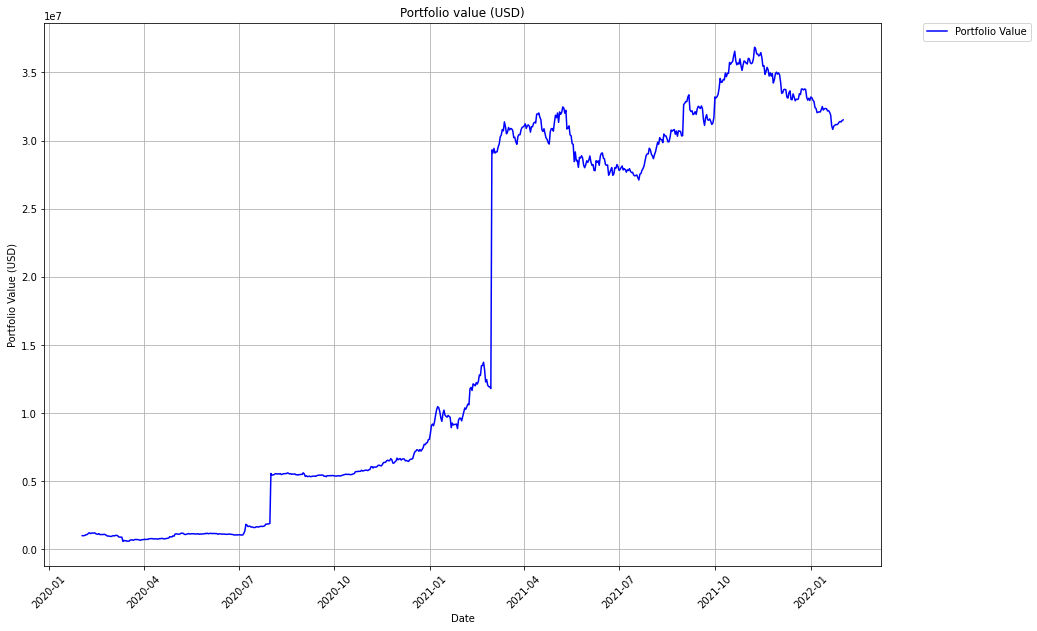

In [39]:
# Portfolio NAV, curve plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
portfolio_df_unrestricted_COMBINED['Portfolio_value']=portfolio_df_unrestricted_COMBINED['Portfolio_value'].fillna(0)
portfolio_df_unrestricted_COMBINED['Date'] = pd.to_datetime(portfolio_df_unrestricted_overlay['Date'])

plt.figure(figsize=(15,10))
plt.plot(portfolio_df_unrestricted_COMBINED['Date'],portfolio_df_unrestricted_COMBINED['Portfolio_value'], 'b', label='Portfolio Value')

plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Portfolio value (USD)')
plt.show()